# Analysis of Gwent Police data 2010 - 2016 by [Huw Fulcher](http://huwfulcher.com)
## Table of Contents

1. [Introduction](#introduction)
2. [Cleaning the data](#cleaning)
3. [Exploring the data](#exploring)
4. [Building a model](#building)
5. [Conclusion](#conclusion)

## <a name="introduction">Introduction</a>
The [UK Police](police.uk) have made [publically accessible data](https://data.police.uk) relating to crime in England, Wales and Northern Ireland in the form of street-level crime and outcome records for each month. The specific data I will be working with is all data collected on the Gwent Police force between 2010 and 2016 (2010 is the oldest data available openly), the reason for chosing Gwent is because it's my local county and it would be interesting to see the landscape of crime in my area!

The notebook will be divided into 3 main sections all of which revolve around using the data provided by the Police. The first section covers importing the data and cleaning it to be usable, thankfully the curators at the Police are good at their job and have left minimal cleaning for me to do.

The second section involves exploring the data with no *a priori* and answering a set of questions that will be outlined in the relevant section.

Finally I will take a look at seeing if a model can be built to classify a crime based on information given.

# <a name="cleaning">Cleaning the data</a>
## Importing 

Mentioned previously the data has been obtained from the UK Police's [open data portal](https://data.police.uk) where a collection of .csv files are provided with each .csv containing all crimes recorded for a certain month in the Gwent Police Force. The first challenge before importing the data was to merge these .csv's together, the quick and dirty way to do this was to use the command:

```shell
cat *.csv > merged.csv
```

While this merges all of the .csv files together it retains the header information of each file which will need to be removed later. Looking at the [changelog](https://data.police.uk/changelog/) of the data an issue was spotted where, *"Gwent Police: An excessive number of crimes have been snapped to Lon Uwchmynydd for January 2015. We are working with the force to establish the cause and resolve this."*, this is a continuing issue and has resulted in leaving out the January 2015 as it could skew analysis and models.

The newly merged .csv file is then imported into the notebook using the pandas library.

In [48]:
%matplotlib inline
%pylab inline

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

csv_file = pd.read_csv("./Data/merged.csv")

Populating the interactive namespace from numpy and matplotlib


## Surveying the data

The first thing to do with any dataset is to get a quick overview of the data, this is done in this instance by using the .describe() command in pandas.

Moving from left to right along the columns we can see a number of issues already. The first is that there is a difference between overall and unique Crime ID's, this could be down to either crimes without an ID or duplicates.

Secondly the attributes *Reported by* and *Falls within* both have two unique values when in reality they should only have one (Gwent Police), without looking at the data first I would say that the issue here is the duplicate headers that are still in the data.

Thirdly, *Context* has only 64 values each of which is the word "Context", this is once again because of the duplicate headers from each separate .csv file but this can be rectified easily by removing the Context column as it provides no information to use.

In [49]:
csv_file.describe()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
count,148476,337403,337403,337403,331841,331841,337403,331821,331821,337403,143299,64
unique,147581,66,2,2,8773,8669,6458,817,817,17,23,1
top,Crime ID,2011-07,Gwent Police,Gwent Police,-3.002860,51.652662,On or near Parking Area,W01001687,Newport 014D,Anti-social behaviour,Investigation complete; no suspect identified,Context
freq,64,7697,337339,337339,2141,2141,10967,9625,9625,151656,72830,64


## Fixing *Crime ID*

Mentioned above, there is a disparity between the count of Crime ID's and the number of unique Crime ID's. This is an issue as the ID should be unique to identify each crime. Taking a quick peak we can see that the first 5 records in the dataset have no ID, depending on the number of crimes with a missing ID this could be a large issue.

In [50]:
csv_file.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2010-12,Gwent Police,Gwent Police,-3.193984,51.798192,On or near Pantyglan,W01001440,Blaenau Gwent 001A,Anti-social behaviour,NaN,NaN
1,NaN,2010-12,Gwent Police,Gwent Police,-3.197188,51.794859,On or near Heol Gwyn Lliw,W01001440,Blaenau Gwent 001A,Anti-social behaviour,NaN,NaN
2,NaN,2010-12,Gwent Police,Gwent Police,-3.193205,51.798910,On or near Lansbury Terrace,W01001440,Blaenau Gwent 001A,Anti-social behaviour,NaN,NaN
3,NaN,2010-12,Gwent Police,Gwent Police,-3.198348,51.795432,On or near Canterbury Road,W01001440,Blaenau Gwent 001A,Anti-social behaviour,NaN,NaN
4,NaN,2010-12,Gwent Police,Gwent Police,-3.197188,51.794859,On or near Heol Gwyn Lliw,W01001440,Blaenau Gwent 001A,Vehicle crime,NaN,NaN


So we have 188927 empty Crime ID's, that's over half of the crime records having a missing ID! This could be an issue and a better way to index the data may be to use an arbitrary index but retain this Crime ID data in case it is useful later on. One thing we can deal with is duplicate ID's! The code below removes duplicates based on ID and doesn't remove NaN ID's.

In [51]:
print(len(csv_file["Crime ID"]) - csv_file["Crime ID"].count())

csv_file = csv_file[(~csv_file["Crime ID"].duplicated()) | (csv_file["Crime ID"].isnull())]
csv_file.describe()

188927


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
count,147581,336508,336508,336508,330953,330953,336508,330933,330933,336508,142404,1
unique,147581,66,2,2,8773,8669,6458,817,817,17,23,1
top,f28dece5cb14ced2c1ed7473198f81080700ba8b3cd269...,2011-07,Gwent Police,Gwent Police,-3.002860,51.652662,On or near Parking Area,W01001687,Newport 014D,Anti-social behaviour,Investigation complete; no suspect identified,Context
freq,1,7697,336507,336507,2141,2141,10929,9591,9591,151656,72638,1


## Fixing *Reported by* and *Falls within*

Another issue faced in the dataset is the two unqiue values found in *Reported by* and *Falls within* where there should be only one unique value (Gwent Police). Looking at the unique values below we can see that the speculation about the csv file headers is confirmed with the headers of files still hanging around. There is only one instance of the header names still remaining so it should be a simple case of dropping records containing the header names.

In [52]:
print(csv_file["Reported by"].value_counts())
print(csv_file["Falls within"].value_counts())

csv_file = csv_file[csv_file["Reported by"] != "Reported by"]
csv_file = csv_file[csv_file["Falls within"] != "Falls within"]

csv_file.describe()

Gwent Police    336507
Reported by          1
Name: Reported by, dtype: int64
Gwent Police    336507
Falls within         1
Name: Falls within, dtype: int64


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
count,147580,336507,336507,336507,330952,330952,336507,330932,330932,336507,142403,0.0
unique,147580,65,1,1,8772,8668,6457,816,816,16,22,0.0
top,f28dece5cb14ced2c1ed7473198f81080700ba8b3cd269...,2011-07,Gwent Police,Gwent Police,-3.002860,51.652662,On or near Parking Area,W01001687,Newport 014D,Anti-social behaviour,Investigation complete; no suspect identified,NaN
freq,1,7697,336507,336507,2141,2141,10929,9591,9591,151656,72638,NaN


## Removing *Context*

Finally the *Context* column needs to be removed as it provides absolutely no information (I wonder why it was included in the first place?).

In [53]:
csv_file.drop("Context", 1, inplace=True)
csv_file.describe()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
count,147580,336507,336507,336507,330952,330952,336507,330932,330932,336507,142403
unique,147580,65,1,1,8772,8668,6457,816,816,16,22
top,f28dece5cb14ced2c1ed7473198f81080700ba8b3cd269...,2011-07,Gwent Police,Gwent Police,-3.002860,51.652662,On or near Parking Area,W01001687,Newport 014D,Anti-social behaviour,Investigation complete; no suspect identified
freq,1,7697,336507,336507,2141,2141,10929,9591,9591,151656,72638


Now the data has been cleaned work can begin on analysing the data given!

# <a name="exploring">Exploring the data</a>

To provide a more structured exploration of the data I have laid out a number of questions to be answered and visualised to get to grips with the data more. Logically, these questions begin as being quite simple moving onto more complex ones.

1. [What are the most common crimes?](#common-crimes)
2. [What areas have the highest crime rates?](#area-crimes)
3. [Is there a geographical correlation to certain crimes?](#geographic-crimes)
4. [Does the time of year affect crime rates?](#time-crime)
5. [Does the type of crime affect the outcome?](#crime-outcome)

## <a name="common-crimes">1. What are the most common crimes?</a>


Let's get the unique types of crime first. We can see the most common crimes from just this list but it isn't exactly pretty. Before we get visualizing let's dig into what "Other theft" and "Other crime" mean, according to the [police.uk FAQ](https://www.police.uk/about-this-site/faqs/#what-do-the-crime-categories-mean) they mean, respectively:

*"Includes theft by an employee, blackmail and making off without payment."*

*"Includes forgery, perjury and other miscellaneous crime."*

These archetype crime types aren't great as they provide us with little detail of the crimes that occured. For now these will be removed in favour of investigating more easily interpreted crimes.

In [54]:
csv_file["Crime type"].value_counts()

Anti-social behaviour           151656
Criminal damage and arson        31497
Violence and sexual offences     24949
Burglary                         24683
Other theft                      23641
Vehicle crime                    19924
Other crime                      19091
Shoplifting                      15310
Drugs                             9857
Violent crime                     7455
Public order                      4434
Bicycle theft                     1325
Robbery                            850
Theft from the person              722
Public disorder and weapons        710
Possession of weapons              403
Name: Crime type, dtype: int64

In [55]:
csv_file = csv_file[csv_file["Crime type"] != "Other theft"]
csv_file = csv_file[csv_file["Crime type"] != "Other crime"]

csv_file["Crime type"].value_counts()

Anti-social behaviour           151656
Criminal damage and arson        31497
Violence and sexual offences     24949
Burglary                         24683
Vehicle crime                    19924
Shoplifting                      15310
Drugs                             9857
Violent crime                     7455
Public order                      4434
Bicycle theft                     1325
Robbery                            850
Theft from the person              722
Public disorder and weapons        710
Possession of weapons              403
Name: Crime type, dtype: int64

Now we've cleaned the crime types up a bit more let's move onto visualizing the crime counts!

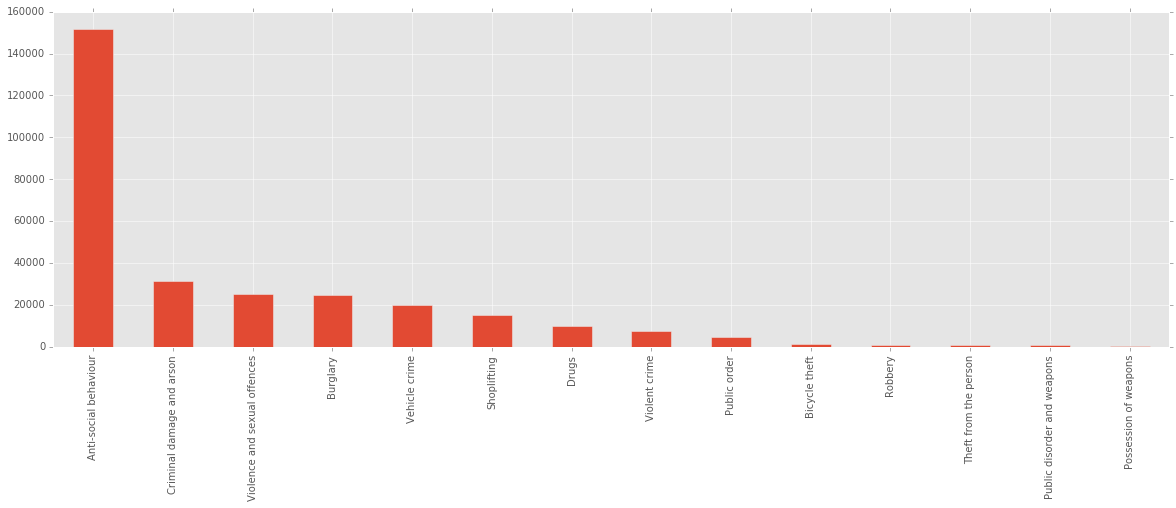

In [56]:
crime_counts = csv_file["Crime type"].value_counts()
figsize(20,6)
crime_counts.plot(kind="bar")

Wow that is a massive jump between anti-social behaviour and the rest of the crime types! Despite the massive jump this isn't unexpected as anti-social behaviour has historically been an issue as highlighted by the graph below. The graph actually shows anti-social behaviour on the decline but a large increase in violence and sexual offences! 2010 and 2016 were omitted as they didn't have crime data for the entire year.

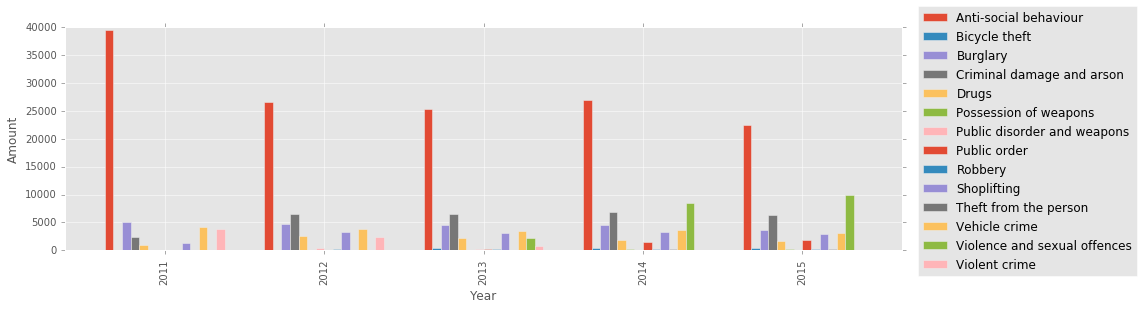

In [84]:
csv_file.loc[:,"Month"] = pd.to_datetime(csv_file["Month"], format="%Y-%m")

crime_years = csv_file[csv_file.Month.dt.year != 2010]
crime_years = crime_years[crime_years.Month.dt.year != 2016]

crime_years = crime_years["Crime type"].groupby(crime_years.Month.dt.year).value_counts()
crime_years = crime_years.unstack()
figsize(15,4)
years_plot = crime_years.plot(kind="bar", width=0.75)
years_plot.set_xlabel("Year")
years_plot.set_ylabel("Amount")
years_plot.legend(loc=9, bbox_to_anchor=(1.15, 1.12))

## <a name="area-crimes">2. What areas have the highest crime rates?</a>




## <a name="geographic-crimes">3. Is there a geographical correlation to certain crimes?</a>


## <a name="time-crime">4. Does the time of year affect crime rates?</a>


## <a name="crime-outcome">5. Does the type of crime affect the outcome?</a>